# A model for chlamydia surveillance data

We propose a three-compartment model of chlamydia infection, testing and screening in a closed population, as illustrated below. Uninfected individuals (U) become infected with a constant incidence, and move to either the asymptomatic-infected (A) or symptomatic-infected (S) pool. Asymptomatic-infected individuals may leave A and return to U by spontaneous clearance of their infection or by detection and treatment under a screening programme. Symptomatic individuals too may clear their infection spontaneously or be screened, but will also seek treatment at a rate which is typically much higher than the rates of spontaneous clearance or screening. 

<img src="figures/3_comp.png", width=400>

This dynamic model has a steady-state solution which depends on the transition rates $\alpha_{UA}$, $\alpha_{AU}$, $\alpha_{US}$ and $\alpha_{SU}$:

In [1]:
import sympy as sym
from sympy import *
A, U, S = symbols("A U S")
alpha_UA, alpha_AU, alpha_US, alpha_SU  = symbols("alpha_UA alpha_AU alpha_US alpha_SU")

model_dyn = [
    alpha_UA*U - alpha_AU*A,
    alpha_AU*A + alpha_SU*S - (alpha_UA + alpha_US)*U,
    alpha_US*U - alpha_SU*S,
    A + U + S - 1 # this equation sets the total population size to 1
    ]

# steady-state solution
sol_dyn = solve(model_dyn, A, U, S)

# functions for calculating the proportion of the population in each compartment at 
# steady state, given transition rates between compartments
dyn_fun = lambdify((alpha_UA, alpha_AU, alpha_US, alpha_SU), sol_dyn[A] + sol_dyn[S])
U_fun = lambdify((alpha_UA, alpha_AU, alpha_US, alpha_SU), sol_dyn[U])
A_fun = lambdify((alpha_UA, alpha_AU, alpha_US, alpha_SU), sol_dyn[A])
S_fun = lambdify((alpha_UA, alpha_AU, alpha_US, alpha_SU), sol_dyn[S])

sol_dyn

{S: alpha_AU*alpha_US/(alpha_AU*alpha_US + alpha_SU*(alpha_AU + alpha_UA)),
 U: alpha_AU*alpha_SU/(alpha_AU*alpha_US + alpha_SU*(alpha_AU + alpha_UA)),
 A: alpha_SU*alpha_UA/(alpha_AU*alpha_US + alpha_SU*(alpha_AU + alpha_UA))}

The transition rates are functions of parameters describing behaviour and the natural history of infection:

$$
\begin{align}
\alpha_{UA} &= \mbox{incidence} \times (1 - p_{symptomatic}) \\
\alpha_{AU} &= \mbox{rate of spontaneous clearance} + \mbox{rate of screening} \times p_{true positive} \\
\alpha_{US} &= \mbox{incidence} \times p_{symptomatic} \\
\alpha_{SU} &= \mbox{rate of spontaneous clearance} + \mbox{rate of screening} \times p_{true positive} + \mbox{rate of symptomatic testing} \times p_{true positive}
\end{align}
$$

Assuming all tests conducted are included in the surveillance data, the number of tests reported per unit time will be:

$$
\mbox{rate of testing} = \mbox{rate of screening} + S \times \mbox{rate of symptomatic testing}
$$

And the number of diagnoses per unit time will be:

\begin{multline*}
\mbox{rate of new diagnoses} = (A+S) \times (\mbox{rate of screening} \times p_{true positive}) \\
+ (U \times \mbox{rate of screening} \times p_{false positive}) \\
+ (S \times \mbox{rate of symptomatic testing} \times p_{truepositive})
\end{multline*}

Let's assume that:

* 87.5% of incident infections are asymptomatic.
* Infections (whether symptomatic or not) clear spontaneously or through background antibiotic use at a rate 4.74 per year.
* Symptomatic cases seek and obtain testing and treatment at a rate 14.2 per year.
* 97.1% of tests in infected individuals return a positive result. 
* 0.314% of tests in uninfected individuals return a positive result.

In [2]:
p_asymp = 0.875
sc = 4.74
att_symp = 14.2
p_true_pos = 0.971
p_false_pos = 0.00314

It is then possible to calculate the steady-state proportion of the population in each compartment given the rate of screening and incidence, and from these proportions to calculate the total prevalence, and the rates of new tests and diagnoses.

In [3]:
%matplotlib inline
from numpy import *
import matplotlib.pyplot as plt

inc = linspace(0, 0.5, 101) # incidence
scr = linspace(0, 0.5, 101) # screening
inc,scr = meshgrid(inc, scr)

# proportion of population in each compartment
ZU = U_fun(inc*p_asymp, sc + scr*p_true_pos, inc*(1-p_asymp), sc + scr*p_true_pos + att_symp*p_true_pos)
ZA = A_fun(inc*p_asymp, sc + scr*p_true_pos, inc*(1-p_asymp), sc + scr*p_true_pos + att_symp*p_true_pos)
ZS = S_fun(inc*p_asymp, sc + scr*p_true_pos, inc*(1-p_asymp), sc + scr*p_true_pos + att_symp*p_true_pos)

Zprev = 1 - ZU
Ztest = scr + ZS*att_symp
Zdiag = (ZA+ZS)*scr*p_true_pos + ZU*scr*p_false_pos + ZS*att_symp*p_true_pos

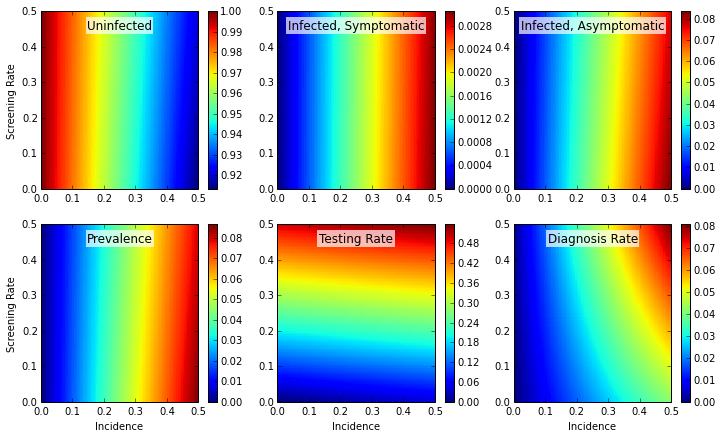

In [4]:
fig = plt.figure(figsize = (12, 7))

ax1 = fig.add_subplot(231)
p = ax1.pcolor(inc,scr, ZU)
cb = fig.colorbar(p, ax=ax1)
#ax1.set_xlabel('Incidence')
ax1.set_ylabel('Screening Rate')
t = ax1.text(0.25, 0.45, 'Uninfected', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax1.set_ylim(0, 0.5)
ax1.set_xlim(0, 0.5)

ax2 = fig.add_subplot(232)
p = ax2.pcolor(inc,scr, ZS)
cb = fig.colorbar(p, ax=ax2)
t = ax2.text(0.25, 0.45, 'Infected, Symptomatic', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax2.set_ylim(0, 0.5)
ax2.set_xlim(0, 0.5)

ax3 = fig.add_subplot(233)
p = ax3.pcolor(inc,scr, ZA)
cb = fig.colorbar(p, ax=ax3)
t = ax3.text(0.25, 0.45, 'Infected, Asymptomatic', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax3.set_ylim(0, 0.5)
ax3.set_xlim(0, 0.5)

ax4 = fig.add_subplot(234)
p = ax4.pcolor(inc,scr, Zprev)
cb = fig.colorbar(p, ax=ax4)
ax4.set_xlabel('Incidence')
ax4.set_ylabel('Screening Rate')
t = ax4.text(0.25, 0.45, 'Prevalence', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax4.set_ylim(0, 0.5)
ax4.set_xlim(0, 0.5)

ax5 = fig.add_subplot(235)
p = ax5.pcolor(inc,scr, Ztest)
cb = fig.colorbar(p, ax=ax5)
ax5.set_xlabel('Incidence')
t = ax5.text(0.25, 0.45, 'Testing Rate', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax5.set_ylim(0, 0.5)
ax5.set_xlim(0, 0.5)

ax6 = fig.add_subplot(236)
p = ax6.pcolor(inc,scr, Zdiag)
cb = fig.colorbar(p, ax=ax6)
ax6.set_xlabel('Incidence')
t = ax6.text(0.25, 0.45, 'Diagnosis Rate', ha='center', size='large')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='None'))
ax6.set_ylim(0, 0.5)
ax6.set_xlim(0, 0.5)

plt.show()   

From the figures, it is clear that a particular pair of observed testing and diagnosis rates corresponds to a single point in the (incidence, screening rate) plane, which in turn corresponds to a particular prevalence. Note, however, that this mapping depends on the parameter values which have been assumed.